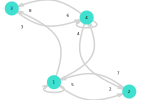

In [9]:
#Graph Being simulated:
using Graphs
using GraphPlot

G = DiGraph(4)#Of the form nodes,edges
#Connections Outwards from node 1 representing Snail
add_edge!(G, 1, 1)
add_edge!(G, 1, 2)
add_edge!(G, 1, 3)
add_edge!(G, 1, 4)
#Connections Outwards from node 2 representing miR34
add_edge!(G, 2, 1)
#Connections Outwards from node 3 representing miR200
add_edge!(G, 3, 4)
#Connections Outwards from node 4 representing Zeb
add_edge!(G, 4, 2)
add_edge!(G, 4, 3)
add_edge!(G, 4, 4)
nvertices = nv(G) # number of vertices
nedges = ne(G)    # number of edges
gplot(G, nodelabel=1:nvertices, edgelabel=1:nedges,linetype="curve")

In [10]:
#Meanings of Graphs for v in vertices(G)
list_vertices = ["Snail","mir200","mir34","Zeb"]
for v in vertices(G)
    vertice_name = list_vertices[v]
    println("vertex $v is $vertice_name")
end

#Meanings of Graphs for e in edges(G)
list_edges = ["Self inhibition of Snail production","Inhibition of miR34 production by Snail","Inhibition of miR200 production by Snail","Stimulation of Zeb production by Snail","Inhibition of Snail Production by miR34","Inhibition of Zeb production by miR200","Inhibition of miR34 production by Zeb","Inhibition of miR200 production by Zeb","Self stimulation of Zeb production"]
#Initialzing j = 0 for indexing
j=0
for e in edges(G)
    j+=1
    u, v = src(e), dst(e) #src is source node of edge e and dst is destination node of edge E
    edge_name = list_edges[j]
    println("edge $u - $v is $edge_name")    
    
end

vertex 1 is Snail
vertex 2 is mir200
vertex 3 is mir34
vertex 4 is Zeb
edge 1 - 1 is Self inhibition of Snail production
edge 1 - 2 is Inhibition of miR34 production by Snail
edge 1 - 3 is Inhibition of miR200 production by Snail
edge 1 - 4 is Stimulation of Zeb production by Snail
edge 2 - 1 is Inhibition of Snail Production by miR34
edge 3 - 4 is Inhibition of Zeb production by miR200
edge 4 - 2 is Inhibition of miR34 production by Zeb
edge 4 - 3 is Inhibition of miR200 production by Zeb
edge 4 - 4 is Self stimulation of Zeb production


In [20]:
#Initializing all packages
using Symbolics,ModelingToolkit,DifferentialEquations,Plots,DataFrames
@variables t H_stim_snail(t) H_inhib_snail(t) H_stim_mir_200(t) H_inhib_mir_200(t) H_stim_mir_34(t) H_inhib_mir_34(t) H_stim_Zeb(t) H_inhib_Zeb(t) Snail(t) mir_34(t) Zeb(t) mir_200(t)# Define variables
@parameters Snail_thres,mir_34_thres,mir_200_thres,Zeb_thres,k_Snail,k_mir_34,k_mir_200,k_Zeb,l_stim_snail,l_stim_mir_34,l_stim_mir_200,l_stim_Zeb,G_Snail,G_mir_200,G_mir_34,G_Zeb

#Naming convention for parameters
#i - inhibitory,s - self,stimulatory - st,snail - sn,zeb - zb,mir34 - m34,mir200 -m200

#Connections to Snail node
#Inhibitory connection of Snail to itself
@variables Snail(t) 
@parameters Snail_thres Hill_Coeff_sisn l_sisn Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_snail_1 = [
  Hill_fn_term1 ~ Snail_thres ^Hill_Coeff_sisn/(Snail ^Hill_Coeff_sisn+ Snail_thres ^Hill_Coeff_sisn),
  Hill_fn_term2 ~ l_sisn*Snail^Hill_Coeff_sisn/((Snail^Hill_Coeff_sisn)+(Snail_thres^Hill_Coeff_sisn)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_snail_1[1].rhs
Hill_fn_term2_expr = equations_snail_1[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_snail_1 = substitute(equations_snail_1[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])

#Inhibitory connection of Snail from mir34
@variables mir_34(t) 
@parameters mir_34_thres Hill_Coeff_m34isn l_m34isn Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_snail_2 = [
  Hill_fn_term1 ~ mir_34_thres ^Hill_Coeff_m34isn/(mir_34 ^Hill_Coeff_m34isn+ mir_34_thres ^Hill_Coeff_m34isn),
  Hill_fn_term2 ~ l_m34isn*mir_34^Hill_Coeff_m34isn/((mir_34^Hill_Coeff_m34isn)+(mir_34_thres^Hill_Coeff_m34isn)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_snail_2[1].rhs
Hill_fn_term2_expr = equations_snail_2[2].rhs
# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_snail_2 = substitute(equations_snail_2[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])
reduced_equation_snail = reduced_equation_snail_1*reduced_equation_snail_2
attempted_snail = substitute((G_Snail*H_stim_snail*H_inhib_snail)/l_stim_snail - k_Snail*Snail,[H_inhib_snail => reduced_equation_snail,H_stim_snail => 1,l_stim_snail =>1])

G_Snail*((Snail_thres^Hill_Coeff_sisn) / (Snail_thres^Hill_Coeff_sisn + Snail(t)^Hill_Coeff_sisn) + (l_sisn*(Snail(t)^Hill_Coeff_sisn)) / (Snail_thres^Hill_Coeff_sisn + Snail(t)^Hill_Coeff_sisn))*((l_m34isn*(mir_34(t)^Hill_Coeff_m34isn)) / (mir_34_thres^Hill_Coeff_m34isn + mir_34(t)^Hill_Coeff_m34isn) + (mir_34_thres^Hill_Coeff_m34isn) / (mir_34_thres^Hill_Coeff_m34isn + mir_34(t)^Hill_Coeff_m34isn)) - k_Snail*Snail(t)

In [21]:
#Connections to Zeb node
#Stimulatory Connection of Zeb to itself:
@variables Zeb(t) 
@parameters Zeb_thres Hill_Coeff_sstzb l_sstzb Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_Zeb_1 = [
  Hill_fn_term1 ~ Zeb_thres ^Hill_Coeff_sstzb/(Zeb ^Hill_Coeff_sstzb+ Zeb_thres ^Hill_Coeff_sstzb),
  Hill_fn_term2 ~ l_sstzb *Zeb^Hill_Coeff_sstzb/((Zeb^Hill_Coeff_sstzb)+(Zeb_thres^Hill_Coeff_sstzb)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_Zeb_1[1].rhs
Hill_fn_term2_expr = equations_Zeb_1[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_Zeb_1 = substitute(equations_Zeb_1[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])

#Stimulatory connection from Snail to Zeb
@variables Snail(t) 
@parameters Snail_thres Hill_Coeff_snstzb l_snstzb Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_Zeb_2 = [
  Hill_fn_term1 ~ Snail_thres ^Hill_Coeff_snstzb/(Snail ^Hill_Coeff_snstzb+ Snail_thres ^Hill_Coeff_snstzb),
  Hill_fn_term2 ~ l_sstzb*Snail^Hill_Coeff_snstzb/((Snail^Hill_Coeff_snstzb)+(Snail_thres^Hill_Coeff_snstzb)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_Zeb_2[1].rhs
Hill_fn_term2_expr = equations_Zeb_2[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_Zeb_2 = substitute(equations_Zeb_2[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])
reduced_equation_Zeb = reduced_equation_Zeb_1 * reduced_equation_Zeb_2

#Inhibitory connection from mir200 to Zeb
@variables mir_200(t) 
@parameters mir_200_thres Hill_Coeff_m200izb l_m200izb Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_Zeb_3 = [
  Hill_fn_term1 ~ mir_200_thres ^Hill_Coeff_m200izb/(mir_200 ^Hill_Coeff_m200izb+ mir_200_thres ^Hill_Coeff_m200izb),
  Hill_fn_term2 ~ l_m200izb *mir_200^Hill_Coeff_m200izb/((mir_200^Hill_Coeff_m200izb)+(mir_200_thres^Hill_Coeff_m200izb)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_Zeb_3[1].rhs
Hill_fn_term2_expr = equations_Zeb_3[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_Zeb_3 = substitute(equations_Zeb_2[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])

#Substituting values into RHS for change of Zeb with time equation
attempted_Zeb = substitute((G_Zeb*H_stim_Zeb*H_inhib_Zeb)/l_stim_Zeb - k_Zeb*Zeb,[H_stim_Zeb =>reduced_equation_Zeb,H_inhib_Zeb => reduced_equation_Zeb_3])

#The l stim_Zeb is actually product of individual l stim_Zeb from the 2 stimulatory connection(From Zeb and Snail)

(G_Zeb*((Snail_thres^Hill_Coeff_snstzb) / (Snail_thres^Hill_Coeff_snstzb + Snail(t)^Hill_Coeff_snstzb) + (l_sstzb*(Snail(t)^Hill_Coeff_snstzb)) / (Snail_thres^Hill_Coeff_snstzb + Snail(t)^Hill_Coeff_snstzb))*((Zeb_thres^Hill_Coeff_sstzb) / (Zeb_thres^Hill_Coeff_sstzb + Zeb(t)^Hill_Coeff_sstzb) + (l_sstzb*(Zeb(t)^Hill_Coeff_sstzb)) / (Zeb_thres^Hill_Coeff_sstzb + Zeb(t)^Hill_Coeff_sstzb))*((l_m200izb*(mir_200(t)^Hill_Coeff_m200izb)) / (mir_200_thres^Hill_Coeff_m200izb + mir_200(t)^Hill_Coeff_m200izb) + (mir_200_thres^Hill_Coeff_m200izb) / (mir_200_thres^Hill_Coeff_m200izb + mir_200(t)^Hill_Coeff_m200izb))) / l_stim_Zeb - k_Zeb*Zeb(t)

In [22]:
#Connections to mir200 node:
#Inhibitory connection by Zeb
@variables Zeb(t) 
@parameters Zeb_thres Hill_Coeff_zbim200 l_zbim200 Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_mir_200_1 = [
  Hill_fn_term1 ~ Zeb_thres ^Hill_Coeff_zbim200/(Zeb ^Hill_Coeff_zbim200+ Zeb_thres ^Hill_Coeff_zbim200),
  Hill_fn_term2 ~ l_zbim200*Zeb^Hill_Coeff_zbim200/((Zeb^Hill_Coeff_zbim200)+(Zeb_thres^Hill_Coeff_zbim200)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_mir_200_1[1].rhs
Hill_fn_term2_expr = equations_mir_200_1[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_mir_200_1 = substitute(equations_mir_200_1[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])

#Inhibitory connection by Snail
@variables Snail(t) 
@parameters Snail_thres Hill_Coeff_snim200 l_snim200 Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_mir_200_2 = [
  Hill_fn_term1 ~ Snail_thres ^Hill_Coeff_snim200/(Snail ^Hill_Coeff_snim200+ Snail_thres ^Hill_Coeff_snim200),
  Hill_fn_term2 ~ l_snim200*Snail^Hill_Coeff_snim200/((Snail^Hill_Coeff_snim200)+(Snail_thres^Hill_Coeff_snim200)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_mir_200_2[1].rhs
Hill_fn_term2_expr = equations_mir_200_2[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_mir_200_2 = substitute(equations_mir_200_2[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])
reduced_equation_mir_200 = reduced_equation_mir_200_1 * reduced_equation_mir_200_2

#Substituting values of RHS for change of mir200 with time
attempted_mir_200 = substitute((G_mir_200*H_stim_mir_200*H_inhib_mir_200)/l_stim_mir_200 - k_mir_200 *mir_200,[H_inhib_mir_200 => reduced_equation_mir_200,H_stim_mir_200 =>1,l_stim_mir_200 => 1])

G_mir_200*((Snail_thres^Hill_Coeff_snim200) / (Snail_thres^Hill_Coeff_snim200 + Snail(t)^Hill_Coeff_snim200) + (l_snim200*(Snail(t)^Hill_Coeff_snim200)) / (Snail_thres^Hill_Coeff_snim200 + Snail(t)^Hill_Coeff_snim200))*((Zeb_thres^Hill_Coeff_zbim200) / (Zeb_thres^Hill_Coeff_zbim200 + Zeb(t)^Hill_Coeff_zbim200) + (l_zbim200*(Zeb(t)^Hill_Coeff_zbim200)) / (Zeb_thres^Hill_Coeff_zbim200 + Zeb(t)^Hill_Coeff_zbim200)) - k_mir_200*mir_200(t)

In [23]:
#Connections to mir_34
#Inhibitory connection by Zeb
@variables Zeb(t) 
@parameters Zeb_thres Hill_Coeff_zbim34 l_zbim34 Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_mir_34_1 = [
  Hill_fn_term1 ~ Zeb_thres ^Hill_Coeff_zbim34/(Zeb ^Hill_Coeff_zbim34+ Zeb_thres ^Hill_Coeff_zbim34),
  Hill_fn_term2 ~  l_zbim34*Zeb^Hill_Coeff_zbim34/((Zeb^Hill_Coeff_zbim34)+(Zeb_thres^Hill_Coeff_zbim34)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_mir_34_1[1].rhs
Hill_fn_term2_expr = equations_mir_34_1[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_mir_34_1 = substitute(equations_mir_34_1[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])

#Inhibitory connection by Snail
@variables Snail(t) 
@parameters Snail_thres Hill_Coeff_snim34 l_snim34 Hill_fn_term1 Hill_fn_term2 Hill_fn
equations_mir_34_2 = [
  Hill_fn_term1 ~ Snail_thres ^Hill_Coeff_snim34/(Snail ^Hill_Coeff_snim34+ Snail_thres ^Hill_Coeff_snim34),
  Hill_fn_term2 ~ l_snim34*Snail^Hill_Coeff_snim34/((Snail^Hill_Coeff_snim34)+(Snail_thres^Hill_Coeff_snim34)),
  Hill_fn ~ Hill_fn_term1 + Hill_fn_term2
]
Hill_fn_term1_expr = equations_mir_34_2[1].rhs
Hill_fn_term2_expr = equations_mir_34_2[2].rhs

# Substitute Hill_fn_term1 and Hill_fn_term2 into the equation for Hill_fn
reduced_equation_mir_34_2 = substitute(equations_mir_34_2[3].rhs, [Hill_fn_term1 => Hill_fn_term1_expr, Hill_fn_term2 => Hill_fn_term2_expr])
reduced_equation_mir_34 = reduced_equation_mir_34_1 * reduced_equation_mir_34_2

#Substituting values of RHS for change of mir200 with time
attempted_mir_34 = substitute((G_mir_34*H_stim_mir_34*H_inhib_mir_34)/l_stim_mir_34 - k_mir_34 *mir_34,[H_inhib_mir_34 => reduced_equation_mir_34, H_stim_mir_34 => 1,l_stim_mir_34 => 1])

G_mir_34*((Snail_thres^Hill_Coeff_snim34) / (Snail_thres^Hill_Coeff_snim34 + Snail(t)^Hill_Coeff_snim34) + (l_snim34*(Snail(t)^Hill_Coeff_snim34)) / (Snail_thres^Hill_Coeff_snim34 + Snail(t)^Hill_Coeff_snim34))*((Zeb_thres^Hill_Coeff_zbim34) / (Zeb_thres^Hill_Coeff_zbim34 + Zeb(t)^Hill_Coeff_zbim34) + (l_zbim34*(Zeb(t)^Hill_Coeff_zbim34)) / (Zeb_thres^Hill_Coeff_zbim34 + Zeb(t)^Hill_Coeff_zbim34)) - k_mir_34*mir_34(t)

In [24]:
D = Differential(t) # Define a differential operator

# Define an array of equations
eqs= [D(Snail) ~ attempted_snail,
D(mir_200) ~ attempted_mir_200,
D(mir_34) ~ attempted_mir_34,
D(Zeb) ~ attempted_Zeb]

# Converting our array of equations into ODE system to solve
@named fol_model = ODESystem(eqs, t)

Model fol_model with 4 equations
States (4):
  Snail(t)
  mir_200(t)
  mir_34(t)
  Zeb(t)
Parameters (30):
  Snail_thres
  G_Snail
  k_Snail
  l_m34isn
  l_sisn
  Hill_Coeff_m34isn
⋮

In [25]:
#Parameter sampling:
#Threshold arbitrarily chosen limits,rest all RACIPE limits from Bionumbers                          
#Order of parameters matches parameters order in the definitions of the ODEs:
    function parameter_generator()
        #Parameters for nodes other than Zeb
        for i in 1:3
        append!(par,rand(Uniform(1,100),1)) #Production Rate
        append!(par,rand(Uniform(1,6),1))#Hill Coefficient
        append!(par,rand(Uniform(30,100),1))# Threshold
        append!(par,rand(Uniform(0.01,1),1))#Inhibitory fold change
        append!(par,rand(Uniform(1,6),1))#Hill Coefficient
        append!(par,rand(Uniform(30,100),1))# Threshold
        append!(par,rand(Uniform(0.01,1),1))#Inhibitory fold 
        append!(par,rand(Uniform(0.1,1),1)) #Degradation Rate
        end
        #Parameters for Zeb node
        for i in 1:2
        append!(par,rand(Uniform(1,100),1)) #Production Rate
        append!(par,rand(Uniform(1,6),1))#Hill Coefficient
        append!(par,rand(Uniform(30,100),1))# Threshold
        append!(par,rand(Uniform(1,100),1)) #Stimulatory Fold Change
        end
        append!(par,rand(Uniform(1,6),1))#Hill Coefficient
        append!(par,rand(Uniform(30,100),1))# Threshold
        append!(par,rand(Uniform(0.01,1),1))#Inhibitory fold change
        ele1 = rand(Uniform(0.01,1),1)[1]
        ele2 = rand(Uniform(0.01,1),1)[1]
        ele = ele1 * ele2
        append!(par,ele) #Division term by stimulatory fold changes
        append!(par,rand(Uniform(0.1,1),1)) #Degradation Rate
    end

parameter_generator (generic function with 1 method)

In [32]:
#Generating Parameters to use:
par = []
using Distributions
parameter_generator()
par

37-element Vector{Any}:
 18.725404755817276
  1.9649475449916989
 42.03008876749886
  0.5735053614967641
  3.493727465955482
 62.73472062038921
  0.02754805915417364
  0.7519590628330002
 97.71615972157281
  1.974011858728867
 89.53290823139554
  0.4002997072095674
  5.643368181597066
  ⋮
  2.510657536393962
 65.11438260662953
 47.54996037799718
 18.32321888545871
  3.2590559330553113
 60.140566953260475
 51.84312496558228
  1.0577846153592638
 43.770723581332064
  0.5618378832257286
  0.1715911942298635
  0.8570260171901157

In [33]:
#Solving the system of ODEs
tspan = [0.0,4.0]#timespan

#Initial condition of concentrations
#Can be changed to vary answers
u0 = []
append!(u0,rand(Uniform(1,30),4))

#Defining an ODEProblem and solving it
prob = ODEProblem(fol_model,u0,tspan,par,check_length = false,abstol = 1e-8,reltol = 1e-8)
sol = solve(prob)

#Saving solution in a dataframe
df = DataFrame(sol)

Row,timestamp,Snail(t),mir_200(t),mir_34(t),Zeb(t)
,Float64,Float64,Float64,Float64,Float64
1,0.0,15.2,19.6349,20.3697,27.1761
2,0.00153099,14.2565,21.7156,18.2713,46.1952
3,0.0023756,13.7614,23.0295,17.2077,54.6844
4,0.00382442,12.952,25.4669,15.5255,66.3419
5,0.00522311,12.2159,27.9796,14.0578,74.5628
6,0.00643123,11.6141,30.2404,12.9023,79.6299
7,0.00711492,11.2868,31.5483,12.2911,81.7937
8,0.00758786,11.0658,32.4631,11.8853,83.0842
9,0.00791528,10.9154,33.1009,11.6123,83.9741


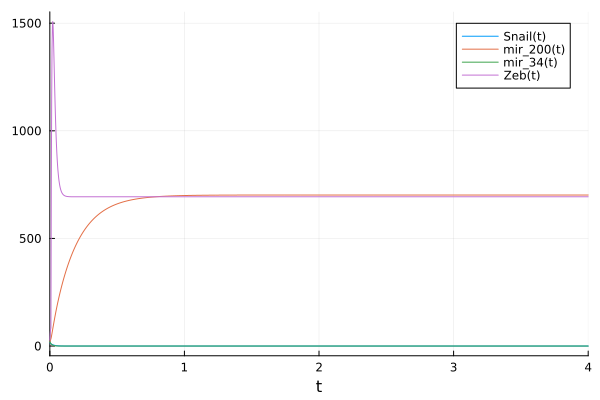

In [34]:
#Plotting our solution to ODEs/Time Series
Plot = plot(sol)

#Save figures if required with below:
#savefig(Plot,"EMT_4_node_iter_8.png")

Sources:
<br>
Source for the 4 node Network:
<br>
[ShapeShifters in Cancer Webinar 30 - Speaker ( Dr Mohit Kumar Jolly) - MANAV The Human Atlas Youtube Channel](https://www.youtube.com/live/pAXQWzoFkzc?si=_hXHFAlMH5TKfRV7&t=1133)
<br>
Source for the equations used in Modelling:
<br>
[Kishore Hari,Varun Ullanat,Archana Balasubramanian,Aditi Gopalan,Mohit Kumar Jolly (2022) Landscape of epithelial–mesenchymal plasticity as an emergent property of coordinated teams in regulatory networks eLife 11:e76535](https://doi.org/10.7554/eLife.76535)
<br>
RACIPE(Random Circuit Perturbation Method) whose equations the previously mentioned paper uses:
<br>
[Huang, B., Jia, D., Feng, J. et al. RACIPE: a computational tool for modeling gene regulatory circuits using randomization. BMC Syst Biol 12, 74 (2018)](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-018-0594-6#citeas)
<br>
<br>
Bionumbers website which the RACIPE method uses to obtain values of parameters:
<br>
 [Bionumbers website](https://bionumbers.hms.harvard.edu/search.aspx)
<br>
  
   